# Comparing Pytorch and MDF model for cats vs dogs images
> This notebooks shows how pytorch models can be created and converted into mdf models. The steps taken in the notebook is shown below.
> - Install packages needed for creating pytorch model and mdf model
> - Define the preprocessing that will be done on any image data fed into the model
> - Build the pytorch model
    - The layers of the resnet50 model was used to train the cats vs dogs dataset
        - The cats vs dogs dataset used in this notebook is a subset of the original data. It can be downloaded from [here](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip).
        - The dataset contains 2000 training data, where each class (cats/dogs) had 1000
        - The dataset contains 1000 validation data, where each class (cats/dogs) had 500
        - The original cats vs dogs dataset which contains 25000 images can be found on [here](https://www.kaggle.com/competitions/dogs-vs-cats/data) on Kaggle
    - The model was evaluated on the validation data with an accuracy of 
    - The model was used to predict on new test image of a cat and dog
> - Build the MDF model (through conversion from pytorch model)
    - Evaluate the model to see that the predictions are the same as pytorch model
> - Build the onnx graph of the model
    

## Packages needed for pytorch and mdf models

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from PIL import Image

from modeci_mdf.interfaces.pytorch import pytorch_to_mdf
from modeci_mdf.execution_engine import EvaluableGraph

## Image preprocessing

In [2]:
# define the transformation (augmentation) for the images
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
])

In [3]:
# define the function that loads the transformation on an image 
def image_loader(loader, image):
    image = loader(image).float()
    image = image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

In [4]:
# load the training datasets into ImageFolder
train_dataset = ImageFolder("Data/cats_and_dogs_filtered/train", transform = transform)

# create data loaders for the training data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# load the test datasets into ImageFolder
test_dataset = ImageFolder("Data/cats_and_dogs_filtered/validation", transform = transform)

# create data loaders for the test data
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

## Pytorch Model

### Training and evaluating RESNET50 Model with Pytorch on Cats vs Dogs dataset

In [5]:
# Define ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer to output 2 classes instead of 1000
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss every 125 batches
        if (i+1) % 125 == 0:
            print ('Batch: {}/{} - Loss: {:.4f}'
                   .format(i+1, len(train_loader), loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Epoch 1/15
Batch: 125/125 - Loss: 0.4428
Epoch 2/15
Batch: 125/125 - Loss: 0.4237
Epoch 3/15
Batch: 125/125 - Loss: 0.4515
Epoch 4/15
Batch: 125/125 - Loss: 0.4164
Epoch 5/15
Batch: 125/125 - Loss: 0.3814
Epoch 6/15
Batch: 125/125 - Loss: 0.1475
Epoch 7/15
Batch: 125/125 - Loss: 0.3356
Epoch 8/15
Batch: 125/125 - Loss: 0.4493
Epoch 9/15
Batch: 125/125 - Loss: 0.5475
Epoch 10/15
Batch: 125/125 - Loss: 0.3638
Epoch 11/15
Batch: 125/125 - Loss: 0.3495
Epoch 12/15
Batch: 125/125 - Loss: 0.4816
Epoch 13/15
Batch: 125/125 - Loss: 0.3141
Epoch 14/15
Batch: 125/125 - Loss: 0.2570
Epoch 15/15
Batch: 125/125 - Loss: 0.3047
Accuracy of the network on the test images: 84.5 %


In [6]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### New cat and dog images to predict on using the trained resnet pytorch model

In [7]:
# getting the directory of the new images to predict on
test_img_dir = "Data/cats_and_dogs_filtered/test"
img_paths = [test_img_dir + "/" + img for img in os.listdir(test_img_dir)]
input_image_0 = Image.open(img_paths[0])
input_image_1 = Image.open(img_paths[1])

In [8]:
# checking the paths for each new image
img_paths

['Data/cats_and_dogs_filtered/test/cat_0.JPEG',
 'Data/cats_and_dogs_filtered/test/dog_0.JPEG']

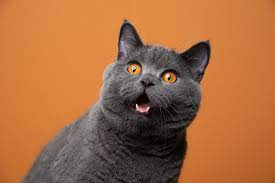

In [9]:
# checking the first image to predict on
input_image_0

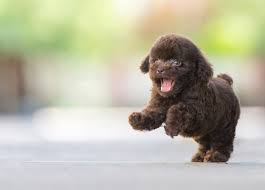

In [10]:
# checking the second image to predict on
input_image_1

In [11]:
# applying the defined transformations on the images
cat_img = image_loader(transform, input_image_0)
dog_img = image_loader(transform, input_image_1)

In [12]:
# creating the map of each class and its index
label_dict = {0 : 'cat', 1: 'dog'}

In [13]:
# prediction on the first image
output_0 = model(cat_img).detach().numpy()
op_label = np.argmax(output_0)
print(label_dict[op_label])

cat


In [14]:
# prediction on the second image
output_1 = model(dog_img).detach().numpy()
op_label = np.argmax(output_1)
print(label_dict[op_label])

dog


## MDF Model

### Convert the ResNet model trained on the cats vs dogs dataset with PyTorch to MDF

In [15]:
mdf_model, params_dict = pytorch_to_mdf(
        model=model,
        args=cat_img,
        trace=True,
    )

In [19]:
# save mdf_model to json and yaml
mdf_model.to_json_file("mdf_model_resnet_cats_dogs.json")
mdf_model.to_yaml_file("mdf_model_resnet_cats_dogs.yaml")

'mdf_model_resnet_cats_dogs.yaml'

### Passing the processed cat image input through MDF model

In [16]:
mdf_graph = mdf_model.graphs[0]
params_dict["input1"] = cat_img.detach().numpy()

eg = EvaluableGraph(graph=mdf_graph, verbose=False)

eg.evaluate(initializer=params_dict)

output_mdf = eg.output_enodes[0].get_output()
op_label_mdf = np.argmax(output_mdf)
print(f"This is a {label_dict[op_label_mdf]}")


Init graph: ResNetGraph
Evaluating graph: ResNetGraph, root nodes: ['Conv_192'], with array format numpy
This is a cat


### MDF Graph

Converting MDF graph: ResNetGraph to graphviz (level: 1, format: png)
    Node: Conv_192
Converting .2 .3 .5 to hex color
    Node: Relu_125
Converting .4 .2 .1 to hex color
    Node: MaxPool_126
Converting .2 .3 .2 to hex color
    Node: Conv_195
Converting .2 .3 .5 to hex color
    Node: Relu_129
Converting .4 .2 .1 to hex color
    Node: Conv_198
Converting .2 .3 .5 to hex color
    Node: Add_132
    Node: Relu_133
Converting .4 .2 .1 to hex color
    Node: Conv_201
Converting .2 .3 .5 to hex color
    Node: Relu_136
Converting .4 .2 .1 to hex color
    Node: Conv_204
Converting .2 .3 .5 to hex color
    Node: Add_139
    Node: Relu_140
Converting .4 .2 .1 to hex color
    Node: Conv_207
Converting .2 .3 .5 to hex color
    Node: Relu_143
Converting .4 .2 .1 to hex color
    Node: Conv_210
Converting .2 .3 .5 to hex color
    Node: Conv_213
Converting .2 .3 .5 to hex color
    Node: Add_148
    Node: Relu_149
Converting .4 .2 .1 to hex color
    Node: Conv_216
Converting .2 .3 .5 to

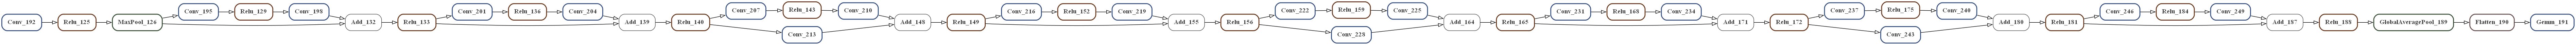

In [17]:
mdf_model.to_graph_image(
    engine="dot",
    output_format="png",
    view_on_render=False,
    level=1,
    filename_root="resnet_50_cats_vs_dogs",
    only_warn_on_fail=True,
    is_horizontal = True
)
from IPython.display import Image
Image(filename="resnet_50_cats_vs_dogs.png")

## ONNX Graph on ResNet50 trained on cats vs dogs data

In [18]:
try:
    from IPython.display import Image
    onnx_graph = Image(filename="resnet_50_cats_vs_dogs.onnx.png")
    display(onnx_graph)
    
except:
    import netron
    torch.onnx.export(
            model,
            cat_img,
            "resnet_50_cats_vs_dogs.onnx",
            verbose=True,
            input_names=[],
            opset_version=9,
        )
    netron.start("resnet_50_cats_vs_dogs.onnx")

graph(%input.1 : Float(1, 3, 128, 128, strides=[49152, 16384, 128, 1], requires_grad=1, device=cpu),
      %fc.weight : Float(2, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(2, strides=[1], requires_grad=1, device=cpu),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %194 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %206 : Float(64, strides=[1], requires_grad=

Serving 'resnet_50_cats_vs_dogs.onnx' at http://localhost:8080
